In [520]:
import os
import pandas as pd
import geopandas as gpd

# os.environ["USE_PYGEOS"] = os.environ.get("USE_PYGEOS", "0")
local_crs = 32636
# path to data
example_data_path = "./data"

In [521]:
# load aggregated info we have
aggregated_blocks = gpd.read_parquet(os.path.join(example_data_path, "data_getter_blocks.parquet"))
accessibility_matrix = pd.read_pickle(os.path.join(example_data_path, "data_getter_matrix.pickle"))

In [522]:
# load data required for service graphs creation
schools = gpd.read_parquet(os.path.join(example_data_path, "schools.parquet"))
kindergartens = gpd.read_parquet(os.path.join(example_data_path, "kindergartens.parquet"))
recreational_areas = gpd.read_parquet(os.path.join(example_data_path, "recreational_areas.parquet")).rename_geometry('geometry')

hospitals = gpd.read_file(os.path.join(example_data_path, "hospitals.geojson"))
pharmacies = gpd.read_file(os.path.join(example_data_path, "pharmacies.geojson"))
policlinics = gpd.read_file(os.path.join(example_data_path, "policlinics.geojson"))

# services should be specified as a dictionary
services = {"schools": schools, "kindergartens": kindergartens, "recreational_areas": recreational_areas,
            "hospitals": hospitals, "pharmacies": pharmacies, "policlinics": policlinics}

In [523]:
from masterplan_tools import CityModel

city_model = CityModel(
  blocks=aggregated_blocks, 
  accessibility_matrix=accessibility_matrix, 
  services=services
)

In [604]:
from pydantic import BaseModel
from pulp import *
from itertools import product
import math
import pandas as pd
import numpy as np

class LpProvision(BaseModel):
    city_model : CityModel
    services : dict = {
        'kindergartens': {'demand': 61, 'accessibility': 10},
        'schools': {'demand': 120, 'accessibility': 15},
        'recreational_areas': {'demand': 6000, 'accessibility': 15 },
        'hospitals': {'demand': 9, 'accessibility': 60},
        'pharmacies': {'demand': 50, 'accessibility': 10},
        'policlinics': {'demand': 27, 'accessibility': 15},
    }

    @staticmethod
    def sum_prov(gdf):
        return gdf['supplied'].sum()/gdf['demand'].sum()

    def get_provision(self, service_type_name, update = None):
        acc_df = self.city_model.accessibility_matrix.df
        blocks = self.city_model.blocks.to_gdf()
        if update != None:
            blocks.loc[update['id'],'current_population'] += update['population']
        blocks['demand'] = (blocks['current_population']/1000*self.services[service_type_name]['demand']).apply(lambda x: math.ceil(x))
        costs = pd.DataFrame(data=acc_df)#.applymap(lambda x : math.exp(x) / self.services[service_type_name]['accessibility'])
        result = pd.DataFrame(index=costs.index, columns=costs.columns)
        demand = blocks['demand']
        capacity = (pd.DataFrame.from_dict(city_model.services_graph.nodes, orient='index').fillna(0)[f'{service_type_name}_capacity']).apply(lambda x: math.ceil(x))
        if update != None:
            capacity.loc[update['id']] += update[f'{service_type_name}_capacity']
        #drop 0 demand
        blocks.drop(labels=list(demand.loc[lambda x : x == 0].index), inplace=True, axis='index')
        costs.drop(labels=list(demand.loc[lambda x : x == 0].index), inplace=True, axis='index')
        demand = demand.loc[lambda x : x > 0]
        #drop 0 capacity
        costs.drop(labels=capacity.loc[lambda x : x == 0].index, inplace=True, axis='columns')
        capacity = capacity.loc[lambda x : x > 0]
        #add fictive blocks to balance the problem
        delta = demand.sum()-capacity.sum()
        last_index = None
        last_column = None
        if delta > 0:
            last_column = costs.iloc[:,-1].name + 1
            costs.loc[:, last_column + 1] = 0
            capacity[last_column + 1] = delta
        if delta < 0:
            last_index = costs.iloc[-1,:].name + 1
            costs.loc[last_index + 1, :] = 0
            demand[last_index + 1] = -delta
        #begin to solve the problem    
        prob = LpProblem('Transportation', LpMinimize)
        x = LpVariable.dicts('Route', product(demand.index, capacity.index), 0, None)
        prob += lpSum(costs.loc[n,m] * x[n,m] for n in demand.index for m in capacity.index)
        for n in demand.index:
            prob += lpSum(x[n,m] for m in capacity.index) == demand[n]
        for m in capacity.index:
            prob += lpSum(x[n,m] for n in demand.index) == capacity[m]
        prob.solve(pulp.PULP_CBC_CMD(msg=False))
        print(LpStatus[prob.status])
        #make the output
        for var in prob.variables():
            value = var.value()
            name = var.name.replace('(', '').replace(')', '').replace(',', '').split('_')
            a = int(name[1])
            b = int(name[2])
            if value > 0 and costs.loc[a,b] <= self.services[service_type_name]['accessibility']:
                if last_index != None and a != (last_index + 1) : result.loc[a,b] = value
                if last_column != None and b != (last_column + 1) : result.loc[a,b] = value
        blocks['demand'] = demand
        blocks['supplied']=result.sum(axis=1)
        blocks['provision'] = blocks['supplied'] / blocks['demand']
        return blocks



In [605]:
lpp = LpProvision(city_model=city_model)

In [606]:
services_prov = {}

for service_type in city_model.get_service_types():
  services_prov[service_type] = lpp.get_provision(service_type)

Optimal
Optimal
Optimal
Optimal
Optimal
Optimal


In [607]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

def prov_charts(provision : dict):
  def show_me_chart(fig, gs, prov, name, i, sum):
    ax = fig.add_subplot(gs[i//3, i%3])
    city_model.blocks.to_gdf().plot(ax=ax, color="#ddd", alpha=1)
    prov.plot(column="provision", legend=True, ax=ax, cmap='RdYlGn', vmin=0, vmax=1)
    ax.set_title(name +" provision: " + f'{sum: .3f}')
  fig = plt.figure(figsize=(25, 15))
  gs = GridSpec(2, 3, figure=fig)
  i = 0
  for service_type in provision:
    prov = services_prov[service_type]
    show_me_chart(fig, gs, prov, service_type, i, LpProvision.sum_prov(prov))
    i = i+1
  plt.show()  

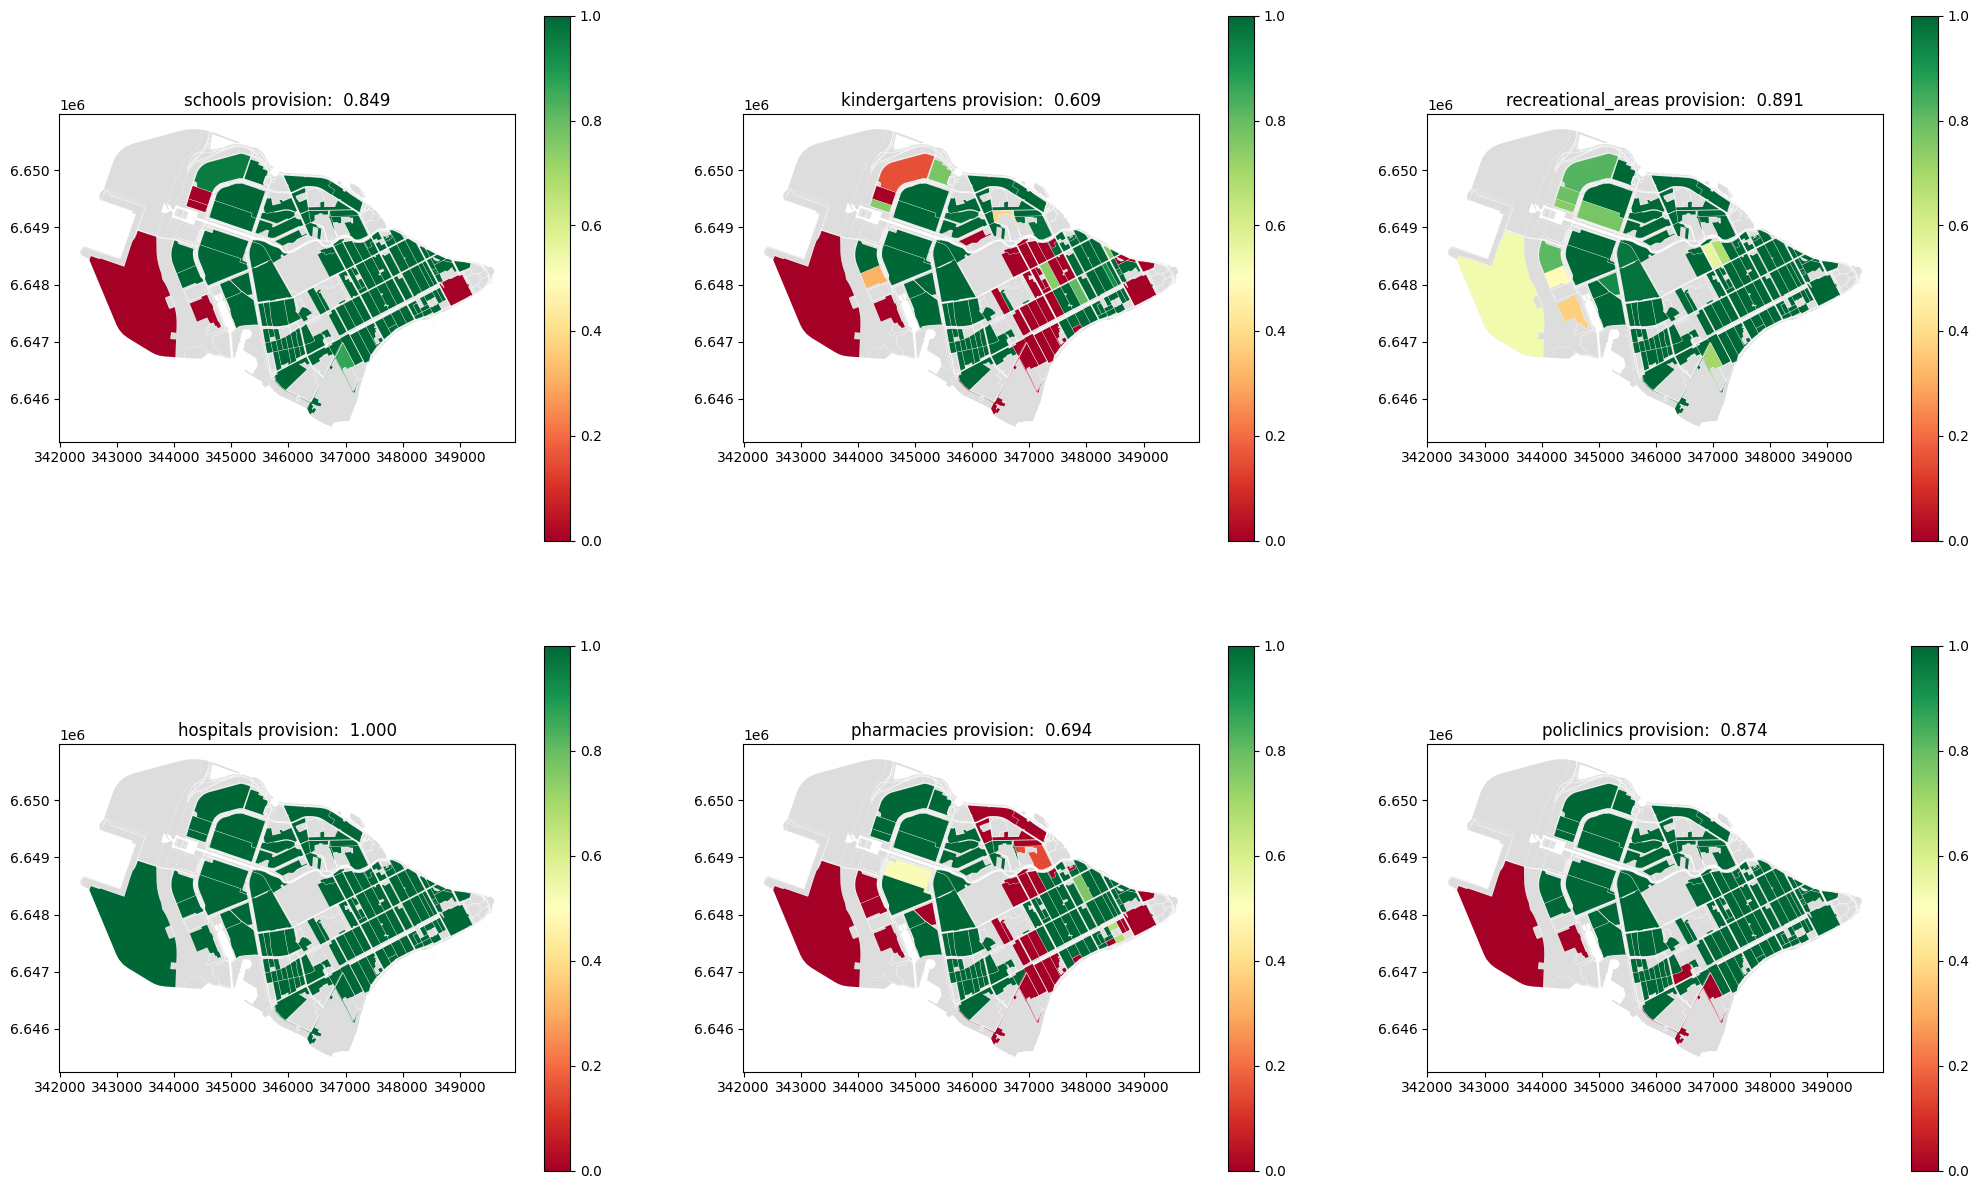

In [608]:
prov_charts(services_prov)

In [612]:
update = {
  'id': 218,
  'population': 1000,
  'kindergartens_capacity': 0,
  'schools_capacity': 0,
  'recreational_areas_capacity': 0,
  'hospitals_capacity': 0,
  'pharmacies_capacity': 0,
  'policlinics_capacity': 0,
}

In [613]:
services_prov = {}

for service_type in city_model.get_service_types():
  services_prov[service_type] = lpp.get_provision(service_type, update)

Optimal
Optimal
Optimal
Optimal
Optimal
Optimal


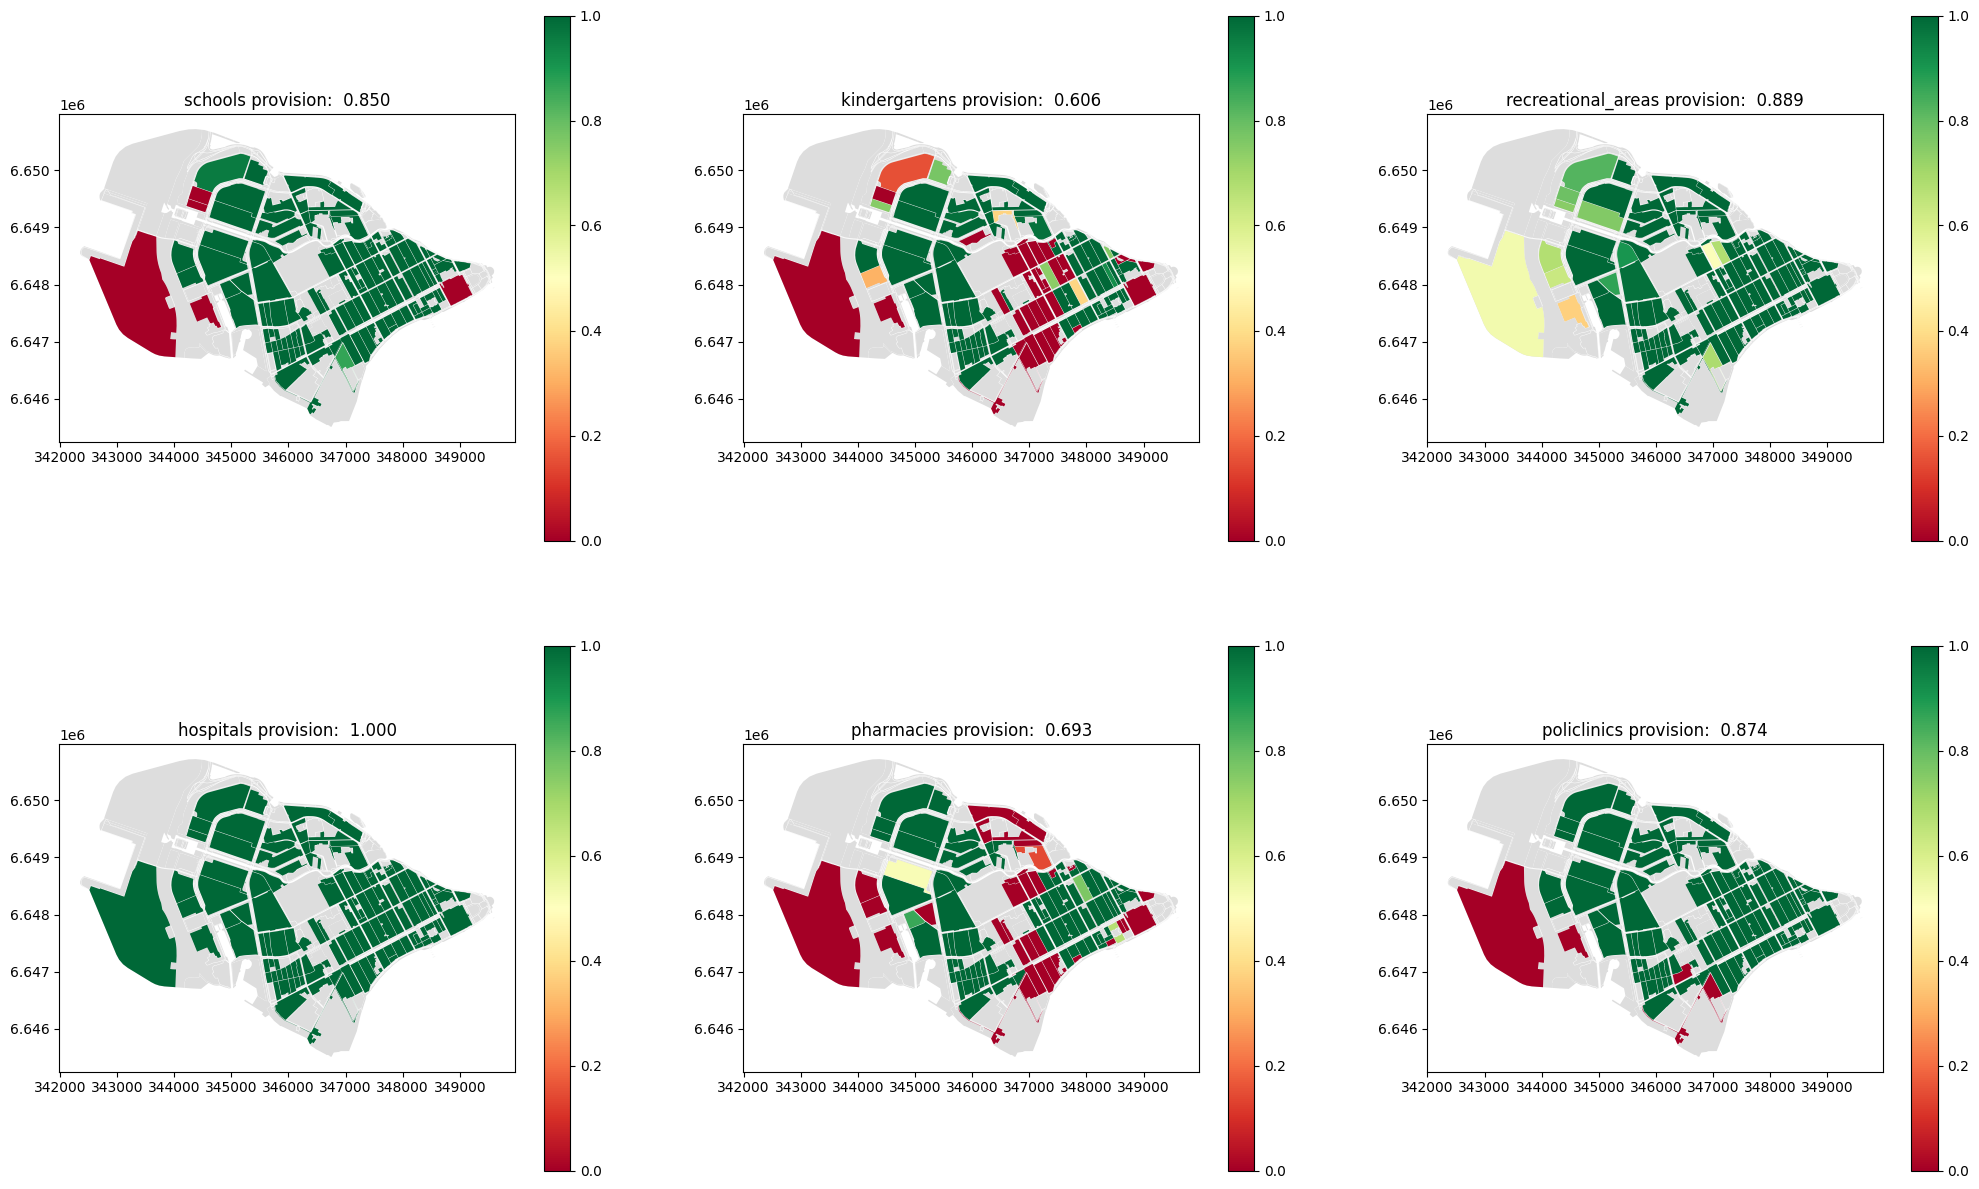

In [614]:
prov_charts(services_prov)